# Split averaged NOE restraints for N states

In [230]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, least_squares
from scipy.optimize import minimize
from scipy import constants as cnst
import scipy.spatial.distance
from sklearn_extra.cluster import KMedoids

from Bio import PDB

import matplotlib.pyplot as plt
import re
import os
import importlib
import sys, traceback

from scipy.spatial import distance_matrix

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['legend.fontsize'] = (14)
plt.rcParams['xtick.labelsize'] = (14)
plt.rcParams['ytick.labelsize'] = (14)
plt.rcParams['font.size'] = (28)
plt.rcParams['text.usetex'] = True

import warnings
warnings.filterwarnings('ignore')

# Define functions

In [231]:
def read_pdb_tomatrix(pdb_file, bundle=True):
    """
    read pdb file and returns a (nr_models, nr_atoms, nr_atoms) distance matrix
    the pdb file contains a bundle of structures, usually from CYANA calculations
    returns a matrix with the mean distances and the standard deviations to the mean distances
    """
    
    parser = PDB.PDBParser()
    structure = parser.get_structure("structure", pdb_file) 
    
    if bundle == True:
        models = []
        for model in structure.get_models():
    
            coords = []
            atom_nr = 0
            atom_list = {}
            for residue_nr, residue in enumerate(model.get_residues()):
        
                for atom in residue.get_atoms():
                    coords.append(atom.coord)
                    atom_list[atom_nr] = [residue.id[1], residue.get_resname(), atom.get_name()]
                    atom_nr = atom_nr + 1
            models.append(coords)
    
    # create distance matrix
    dist_matrix = []
    for model in range(np.array(models).shape[0]):
        dist_matrix.append(distance_matrix(np.array(models)[model], np.array(models)[model]))
    
    dist_matrix = np.array(dist_matrix)
    distance_mean = dist_matrix.mean(axis=0)
    distance_std = dist_matrix.std(axis=0)
    
    return dist_matrix, atom_list, distance_mean, distance_std, np.array(models)

def read_constraints(upl_file, lol_file, csv_read = True, fix_distances=True):
    """
    read constraints files: 7-column text files in CYANA format
    
    returns a pandas dataframe with the following columns:
    "RESNR_1", "RES_1", "ATOM_1", "RESNR_2", "RES_2", "ATOM_2", "LOL", "UPL"
    
    csv_read = True ... use the csv_read function in pandas. This works for files written by this notebook
    csv_read = False ... use the fwf_read function in pandas. This is required for files written by CYANA
    fix_distances = True ... replace LOL < 1.8 OR nan with 1.8 and UPL > 5.5 with 5.5
    """
    

    if csv_read == True:                    
        df_upl = pd.read_csv(upl_file, sep=" ", header=None, index_col=False).loc[0:, 0:6]
        df_lol = pd.read_csv(lol_file, sep=" ", header=None, index_col=False).loc[0:, 0:6]
                     
    else:                   
        df_upl = pd.read_fwf(upl_file, header=None, index_col=False).loc[0:, 0:6]
        df_lol = pd.read_fwf(lol_file, header=None, index_col=False).loc[0:, 0:6]
                     
    df_upl.rename(columns={0: "RESNR_1", 1: "RES_1", 2: "ATOM_1", 3: "RESNR_2", 4: "RES_2", 5: "ATOM_2", 6: "UPL"}, inplace=True)
    df_upl.drop(df_upl.loc[df_upl["UPL"] == 0].index, inplace=True)
    df_upl["RESNR_1"] = df_upl["RESNR_1"].astype(int)
    df_upl["RESNR_2"] = df_upl["RESNR_2"].astype(int)

    df_lol.rename(columns={0: "RESNR_1", 1: "RES_1", 2: "ATOM_1", 3: "RESNR_2", 4: "RES_2", 5: "ATOM_2", 6: "LOL"}, inplace=True)
    df_lol.drop(df_lol.loc[df_lol["LOL"] == 0].index, inplace=True)
    df_lol["RESNR_1"] = df_lol["RESNR_1"].astype(int)
    df_lol["RESNR_2"] = df_lol["RESNR_2"].astype(int)
                     
    df_enoe_all = pd.merge(df_upl, df_lol, on=["RESNR_1", "RES_1", "ATOM_1", "RESNR_2", "RES_2", "ATOM_2"], how="left")
    
    df_enoe_all.drop_duplicates(inplace=True)
                     
    if fix_distances == True:
        df_enoe_all["LOL"] = np.where(df_enoe_all["LOL"]<1.8, 1.8, df_enoe_all["LOL"])
        df_enoe_all["UPL"] = np.where(df_enoe_all["UPL"]>5.5, 5.5, df_enoe_all["UPL"])
        df_enoe_all["LOL"] = np.where(np.isnan(df_enoe_all["LOL"]), 1.8, df_enoe_all["LOL"])
    
    return df_enoe_all

def drop_atompairs(df, discardlist, transpose="keep"):
    """
    df ... dataframe with eNOE restraints
    discardlist ... list of tuples with NOE restraints to drop from df (because of noisy data or bad fit)
    transpose ... keep, transpose, both
    """
    
    df["RESNR_1"] = df["RESNR_1"].astype(int)
    df["RESNR_2"] = df["RESNR_2"].astype(int)
    df["ATOM_1"] = df["ATOM_1"].astype(str)
    df["ATOM_2"] = df["ATOM_2"].astype(str)
    
    for atompair in discardlist:
        #print(atompair)
        #res1 = int(atompair[0].split(".")[0])
        #res2 = int(atompair[1].split(".")[0])
        #atom1 = str(atompair[0].split(".")[1])
        #atom2 = str(atompair[1].split(".")[1])
        
        res1 = int(atompair[0].split(".")[0])
        res2 = int(atompair[1].split(".")[0])
        atom1 = str(atompair[0].split(".")[1])
        atom2 = str(atompair[1].split(".")[1])
        
        
        if transpose == "keep":
            df.drop(df.loc[(df["RESNR_1"]==res1) & (df["ATOM_1"]==atom1) & (df["RESNR_2"]==res2) & (df["ATOM_2"]==atom2)].index, inplace=True)
        if transpose == "transpose":
            df.drop(df.loc[(df["RESNR_2"]==res1) & (df["ATOM_2"]==atom1) & (df["RESNR_1"]==res2) & (df["ATOM_1"]==atom2)].index, inplace=True)
        if transpose == "both":
            df.drop(df.loc[(df["RESNR_1"]==res1) & (df["ATOM_1"]==atom1) & (df["RESNR_2"]==res2) & (df["ATOM_2"]==atom2)].index, inplace=True)
            df.drop(df.loc[(df["RESNR_2"]==res1) & (df["ATOM_2"]==atom1) & (df["RESNR_1"]==res2) & (df["ATOM_1"]==atom2)].index, inplace=True)
        
    return

def avg_noedist(rNOE_1, rNOE_2, p = 0.5):
    """
    returns the population weighted average distance between two nuclei
    r_ik ... distance between proton i and k
    r_jk ... distance between proton j and k
    p ... contribution of r_ik, 0 <= p <= 1
    """
    
    return (p * (1/rNOE_1)**6 + (1 - p ) * (1/rNOE_2)**6)**(-1/6)

def target(rNOE, rNOE_1, rNOE_2, r_1, r_2, sigma_rNOE, sigma_r_1, sigma_r_2, p = 0.5):
    """
    returns a measure of how well the NOE distances fit the averaged NOE distance given two distances (usually from structures) 
    rNOE ... averaged NOE
    r_1 ... radius 1
    r_2 ... radius 2
    p ... population of r_1
    """
    
    # euklidian distance
    if False: 
        f_target = (
                ((avg_noedist(rNOE_1, rNOE_2, p) - rNOE)/sigma_rNOE)**2 + 
                ( p * (rNOE_1 - r_1)/sigma_r_1)**2 + 
                ( (1 - p) * (rNOE_2 - r_2)/sigma_r_2)**2
               )
    #     
    if True:
        f_target = (
                (np.abs(avg_noedist(rNOE_1, rNOE_2, p) - rNOE)/sigma_rNOE) + 
                p * (np.abs(rNOE_1 - r_1)/sigma_r_1) + 
                ( 1 - p ) * (np.abs(rNOE_2 - r_2)/sigma_r_2)
               )
    
    
    return f_target

def plot_kmedoids(atom_nr1, atom_nr2, atom_nr3, atom_nr4, dist_submatrix, labels, filename=""):
                  
    unique_labels = set(labels)
    
    colors = [(0, 0, 1, 1), (1, 0, 0, 1)]
    
    for k, col in zip(unique_labels, colors):

        class_member_mask = labels == k
    
        xy = dist_submatrix[class_member_mask]
        plt.plot(
            xy[:, atom_nr1, atom_nr2],
            xy[:, atom_nr3, atom_nr4],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

        plt.plot(
            dist_submatrix[kmedoids.medoid_indices_[k], atom_nr1, atom_nr2],
            dist_submatrix[kmedoids.medoid_indices_[k], atom_nr3, atom_nr4],
            "o",
            markerfacecolor="cyan",
            markeredgecolor="k",
            markersize=18,
        )
     
    atom_1 = atom_list[atom_nr_list[atom_nr1]]
    atom_2 = atom_list[atom_nr_list[atom_nr2]]
    atom_3 = atom_list[atom_nr_list[atom_nr3]]
    atom_4 = atom_list[atom_nr_list[atom_nr4]]
    
    #distance_1 = str(atom_1[0]) + atom_1[1] + atom_1[2] + "-" + str(atom_2[0]) + atom_2[1] + atom_2[2]
    #distance_2 = str(atom_3[0]) + atom_3[1] + atom_3[2] + "-" + str(atom_4[0]) + atom_4[1] + atom_4[2]
    
    #distance_1 = str(atom_1[0]) + "." + atom_1[2] + "," + str(atom_2[0]) + "." + atom_2[2]
    #distance_2 = str(atom_3[0]) + "." + atom_3[2] + "," + str(atom_4[0]) + "." + atom_4[2]
    
    distance_1 = atom_1[2] + "." + str(atom_1[0]) + "," + atom_2[2] + "." + str(atom_2[0])
    distance_2 = atom_3[2] + "." + str(atom_3[0]) + "," + atom_4[2] + "." + str(atom_4[0])
    
    plt.xlabel(r"\textbf{$\:d(%s) \:\slash\AA $}" %(distance_1), fontsize=22)
    plt.ylabel(r"\textbf{$\:d(%s) \:\slash\AA $}" %(distance_2), fontsize=22)
    
    #plt.xlabel(r"d(%s, %s) $\AA $}" %(str(atom_list[atom_nr_list[i]]), str(atom_list[atom_nr_list[j]])), fontsize=24)
    #plt.ylabel(r"d(%s, %s) $\AA $}" %(str(atom_list[atom_nr_list[i]]), str(atom_list[atom_nr_list[k]])), fontsize=24)
     
    if len(filename) > 0:
        svg_file = filename + atom_1[2] + atom_2[2] + atom_3[2] + atom_4[2] + ".svg"
        plt.savefig(svg_file)
    plt.show()
    return

def subset_restraints(df_restraints, subset_atompairs):
    """
    create dataframe restraints for distances which are given in subset_atompairs
    
    """
    
    for index, atompair in enumerate(subset_atompairs):
        res1 = int(atompair[0].split(".")[1])
        res2 = int(atompair[1].split(".")[1])
        atom1 = str(atompair[0].split(".")[0])
        atom2 = str(atompair[1].split(".")[0])
    
        if index==0:
            #print(index)
            df_subset = df_restraints.loc[        
            
                (df_restraints["RESNR_1"]==res1) & 
                             (df_restraints["ATOM_1"]==atom1) & 
                             (df_restraints["RESNR_2"]==res2) & 
                             (df_restraints["ATOM_2"]==atom2)
                        ]
            
        else:
            #print(index)
            df_subset_newrow = df_restraints.loc[        
            
                (df_restraints["RESNR_1"]==res1) & 
                             (df_restraints["ATOM_1"]==atom1) & 
                             (df_restraints["RESNR_2"]==res2) & 
                             (df_restraints["ATOM_2"]==atom2)
                        ]

            df_subset.append(df_subset_newrow, ignore_index=True)
            df_subset.loc[index] = df_subset_newrow.values.tolist()[0]
            
    return df_subset

# Read upper and lower limit distance restraints

In [232]:
#df_enoe_all = read_constraints(upl_file, lol_file, csv_read = False, fix_distances=True)
dirpath = "/home/Simon/Documents/BNSP/projects/omphalotins/cyana/CD3ODeNOE_unidirect_multistate/"

upl_file = dirpath + "enoecombined.upl"
lol_file = dirpath + "enoecombined.lol"

df_enoe_all = read_constraints(upl_file, lol_file, csv_read = False, fix_distances=True)
df_enoe_all

RESNR_1 RES_1 ATOM_1  RESNR_2 RES_2 ATOM_2   UPL   LOL
0          1   TRP      H        1   TRP    HD1  4.36  4.21
1          1   TRP      H        1   TRP    HE3  3.84  3.64
2          1   TRP    HB2        1   TRP    HD1  3.73  3.06
3          1   TRP    HB2        1   TRP    HE3  3.70  3.05
4          1   TRP    HB3        1   TRP    HD1  3.73  3.06
..       ...   ...    ...      ...   ...    ...   ...   ...
170        1   TRP      N       12   SAR      O  2.25  2.25
171        1   TRP      H       12   SAR      O  3.16  3.16
172        1   TRP     CA       12   SAR      O  2.76  2.76
173        1   TRP      H       12   SAR     CA  2.66  2.66
174        1   TRP     CA       12   SAR     CA  3.82  3.82

[166 rows x 8 columns]

# Read the pdb file and create the distance matrix

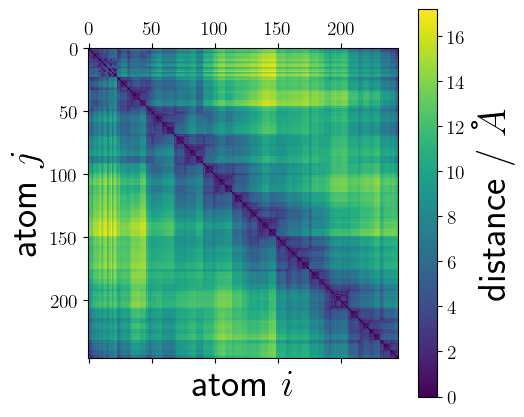

In [233]:
pdb_file ='/home/Simon/Documents/BNSP/projects/omphalotins/cyana/CD3ODeNOE_unidirect_multistate/finaleNOEnoviol.pdb' 

dist_matrix, atom_list, distance_mean, distance_std, coords = read_pdb_tomatrix(pdb_file, bundle=True)
plt.matshow(distance_mean)
plt.xlabel(r"atom $i$")
plt.ylabel(r"atom $j$")
plt.colorbar(label="distance / $\AA$")
plt.show()

In [234]:
atom_1 = [1, 'TRP', 'HB2']
atom_2 = [1, 'TRP', 'HB3']

atom_nr1 = [nr for nr in atom_list.keys() if atom_list[nr] == atom_1][0]
atom_nr2 = [nr for nr in atom_list.keys() if atom_list[nr] == atom_2][0]
print("Mean distance and STD between atom %s and %s " %(atom_1, atom_2) + 
      " = " + str(round(distance_mean[atom_nr1][atom_nr2], 2)) + " +/-" + str(round(distance_std[atom_nr1][atom_nr2], 2)) + " A")

Mean distance and STD between atom [1, 'TRP', 'HB2'] and [1, 'TRP', 'HB3']  = 1.76 +/-0.0 A


In [235]:
#atom_list

# For illustrative purposes: compute the average population weighted distance

In [236]:
fun = lambda r: target(rNOE, r[0], r[1], r_1, r_2, sigma_rNOE, sigma_r_1, sigma_r_2, p)

p = 0.5           # population 2-state model
rNOE = 3.75       # constraint from eNOE
sigma_rNOE = 0.5  # standard deviation
r_1 = 4.0
r_2 = 3.4
sigma_r_1 = 1     # standard deviation
sigma_r_2 = 1     # standard deviation

bnds = ((1.8, None), (1,8, None))
res = minimize(fun, [3, 3], method='SLSQP')#, bounds=bnds)

print("distances at min: " + str(res.x))
print("average NOE distance at min: " + str(avg_noedist(res.x[0], res.x[1])))

distances at min: [4.00000058 3.57798109]
average NOE distance at min: 3.7486356809407506


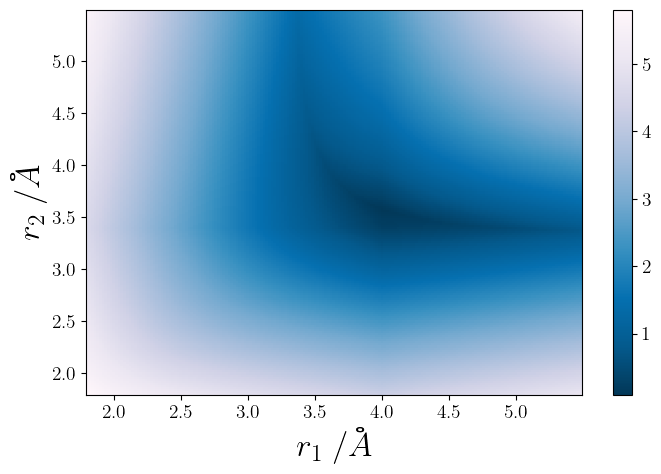

In [237]:
#fig, (ax0, ax1) = plt.subplots(2, 1)

x = np.arange(1.8, 5.5, 0.02)
y = np.arange(1.8, 5.5, 0.02)

X, Y = np.meshgrid(x, y)
Z = target(rNOE, X, Y, r_1, r_2, sigma_rNOE, sigma_r_1, sigma_r_2, p = 0.5)

fig, ax0= plt.subplots( )

c = ax0.pcolor(X, Y, Z,  cmap='PuBu_r')
fig.colorbar(c, ax=ax0)

ax0.set_xlabel(r"\textbf{$r_{1}\;/ \AA $}", fontsize=24)
ax0.set_ylabel(r"\textbf{$r_{2}\;/ \AA $}", fontsize=24)

plt.show()

# List distances for Trp 1 side chain protons

In [238]:
violated_noe = ([("H.1","HD1.1"),
                        ('HB3.1','HD1.1'),
                        ("HB3.1","HE3.1"),
                        ("HA.1","HE3.1"),
                        ("HE1.1","QN.2"),
                        ("HA.1", "HD1.1")
                      #  ("HE3.1","QQG.2"),
                      #  ("HE3.1","QG1.2"),
                      #  ("HE3.1","QG2.2"),
                      #  ("HE3.1","HA.2"),
                        ])  
df_row_TRP1 = subset_restraints(df_enoe_all, violated_noe)

In [239]:
df_row_TRP1

RESNR_1 RES_1 ATOM_1  RESNR_2 RES_2 ATOM_2   UPL   LOL
0        1   TRP      H        1   TRP    HD1  4.36  4.21
1        1   TRP    HB3        1   TRP    HD1  3.73  3.06
2        1   TRP    HB3        1   TRP    HE3  3.70  3.05
3        1   TRP     HA        1   TRP    HE3  4.30  1.80
4        1   TRP    HE1        2   MVA     QN  5.50  1.80
5        1   TRP     HA        1   TRP    HD1  4.70  3.14

In [240]:
# iterate through each conformation and compute the difference to all other conformations

model_hits = []
atom_nr_list = []

for index, row in df_row_TRP1.iterrows():
    atom_1 = [int(row['RESNR_1']), row['RES_1'], row['ATOM_1']]
    atom_2 = [int(row['RESNR_2']), row['RES_2'], row['ATOM_2']]
     
    try:
        # find atom number corresponding to atom in list
        atom_nr1 = [nr for nr in atom_list.keys() if atom_list[nr] == atom_1][0]
        atom_nr2 = [nr for nr in atom_list.keys() if atom_list[nr] == atom_2][0]
             
        r_1 = dist_matrix[0, atom_nr1, atom_nr2]
        sigma_r_1 = dist_matrix[0, atom_nr1, atom_nr2]
        
        df_row = pd.DataFrame(row).transpose()
        
        df_row["r_1"] = np.round(r_1, 2)
        df_row["s_r_1"] = np.round(sigma_r_1, 2)
        
        dist_covar = []
        
        for column in atom_nr_list:
            dist_covar.append(np.cov(dist_matrix_norm[:, atom_nr1, atom_nr2], dist_matrix_norm[:, atom_nr1, column], bias=True)[1][0])
       
        
        if index == 0:
            df_row_all = df_row.copy(deep=True)
            dist_covar_all = np.array(dist_covar)
            #print(df_row_all)
        
        if index > 0:
            #pd.concat([df_row,df_row], axis=1)
            #df_upl.merge(df_row, left_index=True, right_index=True)
            df_row_all.append(df_row, ignore_index=True)
            df_row_all.loc[index] = df_row.values.tolist()[0]
            dist_covar_all = np.vstack([dist_covar_all, np.array(dist_covar)])
            
            #print(df_row)
            #print(index)
        
        
    except:
        pass
        print("something happened")
        traceback.print_exc()

In [241]:
df_row_all

RESNR_1 RES_1 ATOM_1 RESNR_2 RES_2 ATOM_2   UPL   LOL   r_1  s_r_1
0       1   TRP      H       1   TRP    HD1  4.36  4.21  5.41   5.41
1       1   TRP    HB3       1   TRP    HD1  3.73  3.06  2.59   2.59
2       1   TRP    HB3       1   TRP    HE3   3.7  3.05  4.19   4.19
3       1   TRP     HA       1   TRP    HE3   4.3   1.8  2.08   2.08
4       1   TRP    HE1       2   MVA     QN   5.5   1.8  7.87   7.87
5       1   TRP     HA       1   TRP    HD1   4.7  3.14  4.38   4.38

In [242]:
# drop meaningless constraints for Trp 1

delete_list = [["HD1", "HE1"], ["HE3", "HZ3"], ["HE1", "HZ2"], ["HZ2", "HH2"]]#, ["HA", "HD1"]]

def remove_constraints(df_constraints, delete_list):
     
    for atompair in delete_list:
        atom_1 = atompair[0] 
        atom_2 = atompair[1]
        df_constraints.drop(df_constraints.loc[df_constraints["ATOM_1"].str.contains(atom_1, regex=True) & df_constraints["ATOM_2"].str.contains(atom_2, regex=True) &
          (df_constraints["RESNR_1"] == df_constraints["RESNR_1"])].index, inplace=True)

remove_constraints(df_row_TRP1, delete_list)

In [243]:
# create a list of atom_nr for atoms involved in TRP 1 side chain NOEs
# create a matrix with 1 at intersection of atoms involved in an NOE

atom_nr_list = []
noe_mask = np.zeros((len(atom_list), len(atom_list)))

for index, row in df_row_TRP1.iterrows():
    #print(row)
    atom_1 = [int(row['RESNR_1']), row['RES_1'], row['ATOM_1']]
    atom_2 = [int(row['RESNR_2']), row['RES_2'], row['ATOM_2']]
    
    for nr in atom_list.keys():
        if ( atom_list[nr] == atom_1 ):
            atom_nr1 = nr
            
    for nr in atom_list.keys():
        if ( atom_list[nr] == atom_2 ):
            atom_nr2 = nr
            
    noe_mask[atom_nr1][atom_nr2] = 1
    noe_mask[atom_nr2][atom_nr1] = 1
    
            
    atom_nr_list.append(atom_nr1)
    atom_nr_list.append(atom_nr2)
    #print(atom_nr_list)

    atom_nr_list = list(set(atom_nr_list))
    atom_nr_list.sort()

In [244]:
dist_submatrix = dist_matrix[np.ix_(range(dist_matrix.shape[0]), atom_nr_list, atom_nr_list)]
noe_mask_submatrix = noe_mask[np.ix_(atom_nr_list, atom_nr_list)]

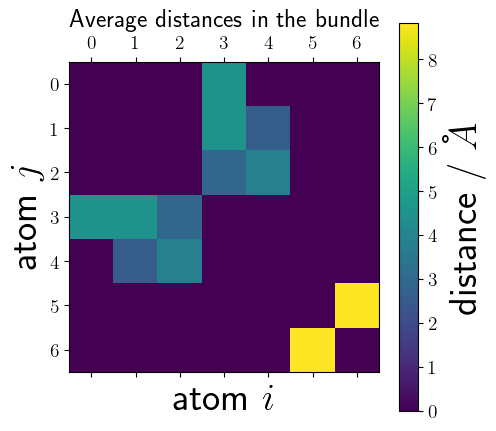

Atom list
---------------------
0 : [1, 'TRP', 'H']
1 : [1, 'TRP', 'HA']
2 : [1, 'TRP', 'HB3']
3 : [1, 'TRP', 'HD1']
4 : [1, 'TRP', 'HE3']
5 : [1, 'TRP', 'HE1']
6 : [2, 'MVA', 'QN']


Atom nr. in pdb file
----------------------
[1, 3, 6, 14, 15, 18, 26]


In [245]:
plt.matshow(dist_submatrix.mean(axis=0)*noe_mask_submatrix)
plt.title("Average distances in the bundle", size=18)
plt.xlabel(r"atom $i$")
plt.ylabel(r"atom $j$")
plt.colorbar(label="distance / $\AA$")
plt.show()


print("Atom list")
print("---------------------")

index = 0
for i in atom_nr_list:
    print(str(index) + " : " + str(atom_list[i]))
    index = index + 1

print("\n")
print("Atom nr. in pdb file")
print("----------------------")
print(atom_nr_list)

In [246]:
atom_1 = [1, 'TRP', 'HE1']
#atom_2 = [1, 'TRP', 'HD1']
atom_2 = [2, 'MVA', 'QN']

atom_nr1 = [nr for nr in atom_list.keys() if atom_list[nr] == atom_1][0]
atom_nr2 = [nr for nr in atom_list.keys() if atom_list[nr] == atom_2][0]
print("Mean distance and STD between atom %s and %s " %(atom_1, atom_2) + 
      " = " + str(round(distance_mean[atom_nr1][atom_nr2], 2)) + " +/-" + str(round(distance_std[atom_nr1][atom_nr2], 2)) + " A")

#plt.hist(dist_matrix[:, atom_nr1, atom_nr2])

Mean distance and STD between atom [1, 'TRP', 'HE1'] and [2, 'MVA', 'QN']  = 8.83 +/-0.91 A


# k-medoids clustering

In [247]:
# user upper triangular matrix np.triu() otherwise distances are counted double

dist_submatrix = np.triu(dist_submatrix * noe_mask_submatrix)

X = dist_submatrix.flatten().reshape(dist_submatrix.shape[0],dist_submatrix.shape[1]*dist_submatrix.shape[2])

In [248]:
nr_clusters = 2
kmedoids = KMedoids(metric="euclidean", n_clusters=nr_clusters).fit(X)
labels = kmedoids.labels_

In [249]:
clusters = {}
for cluster_id in range(nr_clusters):
    cluster = {}
    for i in range(labels.shape[0]):
        cluster[i] = np.round(np.linalg.norm(X[i] - X[kmedoids.medoid_indices_[cluster_id]]), 2)

    clusters[cluster_id] = {k: v for k, v in sorted(cluster.items(), key=lambda item: item[1])}
    print("--------------------------------------------------------------")
    print(list(clusters[cluster_id].keys())[0:10])
    print(list(clusters[cluster_id].values())[0:10])

--------------------------------------------------------------
[0, 6, 50, 82, 22, 15, 26, 42, 58, 38]
[0.0, 0.06, 0.09, 0.09, 0.11, 0.18, 0.21, 0.22, 0.23, 0.26]
--------------------------------------------------------------
[2, 17, 18, 9, 16, 35, 48, 55, 10, 30]
[0.0, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03, 0.04, 0.04]


In [250]:
kmedoids.medoid_indices_[0]

0

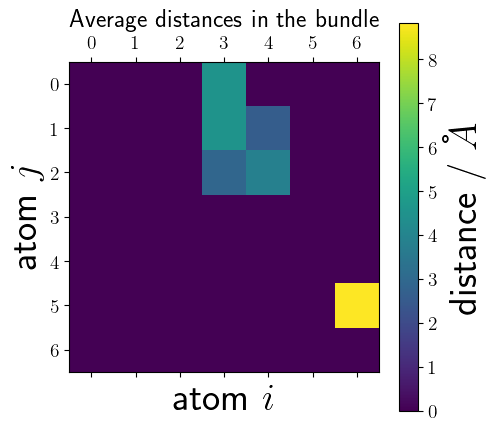

Atom list
---------------------
0 : [1, 'TRP', 'H']
1 : [1, 'TRP', 'HA']
2 : [1, 'TRP', 'HB3']
3 : [1, 'TRP', 'HD1']
4 : [1, 'TRP', 'HE3']
5 : [1, 'TRP', 'HE1']
6 : [2, 'MVA', 'QN']


Atom nr. in pdb file
----------------------
[1, 3, 6, 14, 15, 18, 26]


In [251]:
plt.matshow(dist_submatrix.mean(axis=0)*noe_mask_submatrix)
plt.title("Average distances in the bundle", size=18)
plt.xlabel(r"atom $i$")
plt.ylabel(r"atom $j$")
plt.colorbar(label="distance / $\AA$")
plt.show()


print("Atom list")
print("---------------------")

index = 0
for i in atom_nr_list:
    print(str(index) + " : " + str(atom_list[i]))
    index = index + 1

print("\n")
print("Atom nr. in pdb file")
print("----------------------")
print(atom_nr_list)

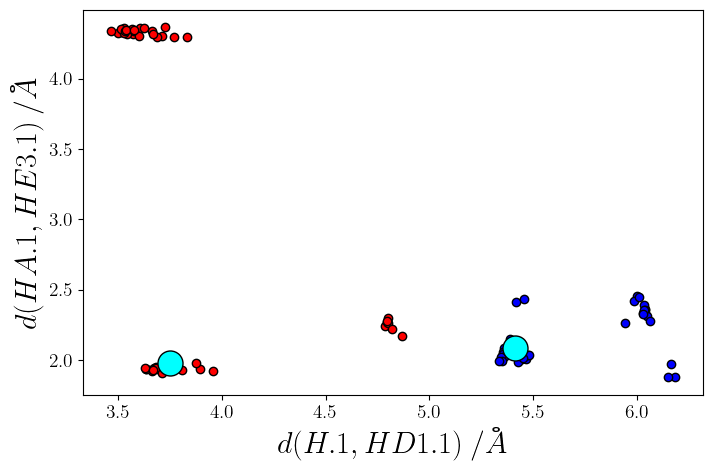

In [252]:
plot_kmedoids(0, 3, 1, 4, dist_submatrix, labels, filename="Trp1.svg")

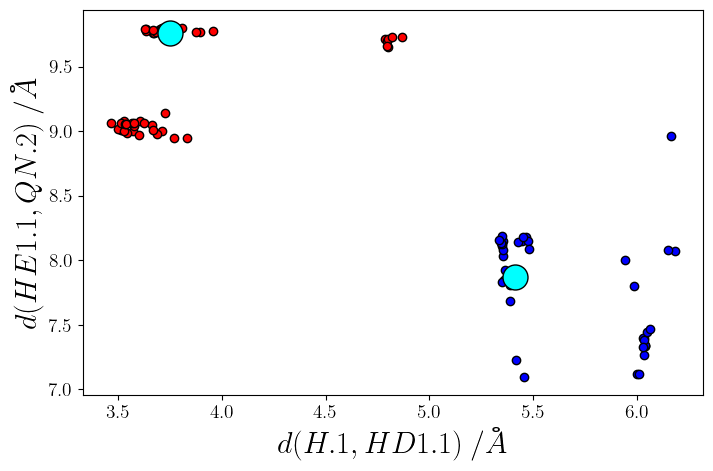

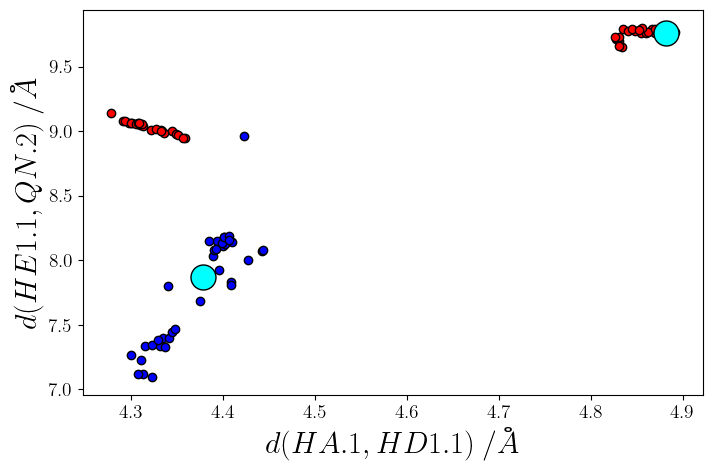

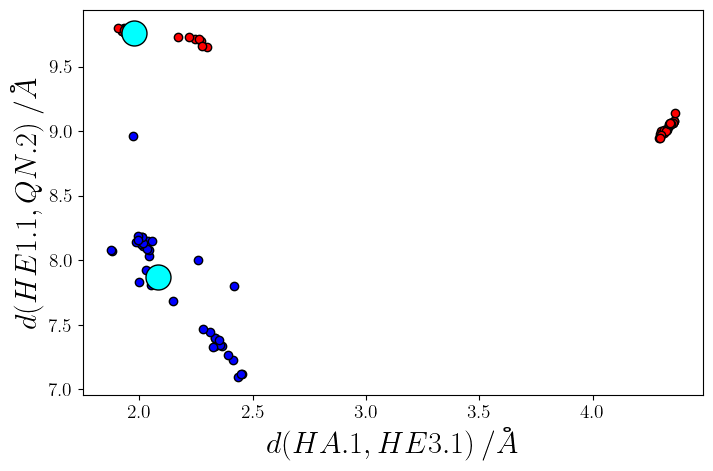

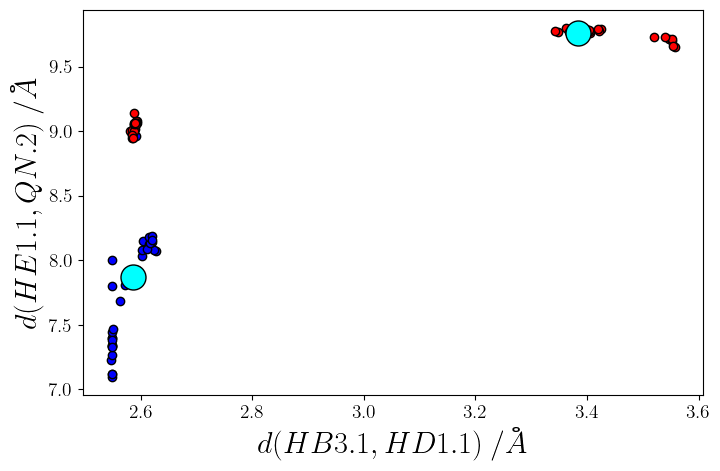

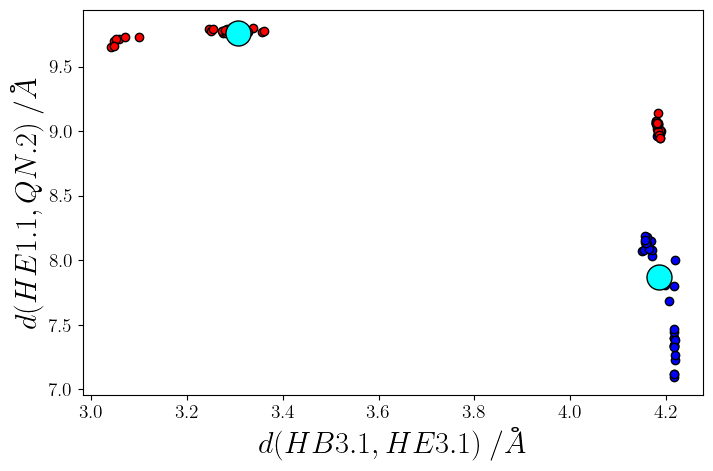

In [253]:
for i in range(dist_submatrix.shape[1]):
    for j in range(dist_submatrix.shape[1]):
        if dist_submatrix[1][i][j] > 0:
            for k in range(dist_submatrix.shape[1])[j:]:
                for l in range(dist_submatrix.shape[1])[j:]:
                    if (dist_submatrix[0][i][j] > 0) & (dist_submatrix[0][k][l] > 0):
                        if j != k:
                            plot_kmedoids(i, j, k, l, dist_submatrix, labels, filename="Trp1")                    

# Split NOEs into restraints for N mediods

In [254]:
medoid_1 = kmedoids.medoid_indices_[0]
medoid_2 = kmedoids.medoid_indices_[1]

row = df_row_TRP1.iloc[1]

atom_1 = [int(row['RESNR_1']), row['RES_1'], row['ATOM_1']]
atom_2 = [int(row['RESNR_2']), row['RES_2'], row['ATOM_2']]

atom_nr1 = [nr for nr in atom_list.keys() if atom_list[nr] == atom_1][0]
atom_nr2 = [nr for nr in atom_list.keys() if atom_list[nr] == atom_2][0]

print(row)
dist_matrix[medoid_1][atom_nr1][atom_nr2]

RESNR_1       1
RES_1       TRP
ATOM_1      HB3
RESNR_2       1
RES_2       TRP
ATOM_2      HD1
UPL        3.73
LOL        3.06
Name: 1, dtype: object


2.5868128281387848

In [259]:
#dist_matrix_norm = np.array(dist_matrix) - np.array(dist_matrix).mean(axis=0)

medoid_1 = kmedoids.medoid_indices_[0]
medoid_2 = kmedoids.medoid_indices_[1]
               
for index, row in df_row_TRP1.iterrows():
    atom_1 = [int(row['RESNR_1']), row['RES_1'], row['ATOM_1']]
    atom_2 = [int(row['RESNR_2']), row['RES_2'], row['ATOM_2']]
        
    try:
        atom_nr1 = [nr for nr in atom_list.keys() if atom_list[nr] == atom_1][0]
        atom_nr2 = [nr for nr in atom_list.keys() if atom_list[nr] == atom_2][0]

             
        # cluster ID starts counting at 1
        # frame ID starts counting at 0
        # frameID = clusterID -1
        
        r_1 = dist_matrix[medoid_1][atom_nr1][atom_nr2]
        r_2 = dist_matrix[medoid_2][atom_nr1][atom_nr2]
        sigma_r_1 = distance_std[atom_nr1][atom_nr2]
        sigma_r_2 = distance_std[atom_nr1][atom_nr2]
        
             
        
        df_row = pd.DataFrame(row).transpose()
        
        sigma_rNOE = 1.0
        #sigma_r_1 = 1.0
        #sigma_r_2 = 1.0
                              
                              
        rNOE = row["UPL"]
        bnds = ((r_1, None), (r_2, None))
        fun = lambda r: target(rNOE, r[0], r[1], r_1, r_2, sigma_rNOE, sigma_r_1, sigma_r_2, p = 0.5)
        res_upl = minimize(fun, [3, 3], method='SLSQP', bounds=bnds)
        
        rNOE = row["LOL"]
        bnds = ((1.8, r_1), (1.8, r_2))
        fun = lambda r: target(rNOE, r[0], r[1], r_1, r_2, sigma_rNOE, sigma_r_1, sigma_r_2, p = 0.5)
        res_lol = minimize(fun, [3, 3], method='SLSQP', bounds=bnds)
        
        rNOE_1_LOL = min(res_lol.x[0], res_upl.x[0])
        rNOE_1_UPL = max(res_lol.x[0], res_upl.x[0])
        
        rNOE_2_LOL = min(res_lol.x[1], res_upl.x[1])
        rNOE_2_UPL = max(res_lol.x[1], res_upl.x[1])
                              
        df_row["r_avg"] = np.round(avg_noedist(rNOE_1_UPL, rNOE_2_UPL, p = 0.5), 2)
        df_row["r_1"] = np.round(r_1, 2)
        df_row["r_2"] = np.round(r_2, 2)
        df_row["rNOE_1_LOL"] = np.round(min(res_lol.x[0], res_upl.x[0]), 2)       
        df_row["rNOE_2_LOL"] = np.round(min(res_lol.x[1], res_upl.x[1]), 2)     
        df_row["rNOE_1_UPL"] = np.round(max(res_lol.x[0], res_upl.x[0]), 2)
        df_row["rNOE_2_UPL"] = np.round(max(res_lol.x[1], res_upl.x[1]), 2)
        
        if index == 0:
            df_row_all = df_row.copy(deep=True)
            #print(df_row_all)
        
        if index > 0:
            #pd.concat([df_row,df_row], axis=1)
            #df_upl.merge(df_row, left_index=True, right_index=True)
            df_row_all.append(df_row, ignore_index=True)
            df_row_all.loc[index] = df_row.values.tolist()[0]
              
    except:
        pass
        print("something happened")
        traceback.print_exc()

In [260]:
df_row_all.rename(columns={"RESNR_1":"1", "RES_1":"RES1", "ATOM_1":"A1", "RESNR_2":"2", "RES_2":"RES2", "ATOM_2":"A2", "rNOE_1_LOL": "1_LOL", 
                          "rNOE_2_LOL": "2_LOL", "rNOE_1_UPL": "1_UPL", "rNOE_2_UPL": "2_UPL"})[["1", "RES1", "A1", "2", "RES2", "A2", "r_avg", "UPL", "1_UPL", "r_1","2_UPL", "r_2", "LOL", "1_LOL", "2_LOL"]]

1 RES1   A1  2 RES2   A2  r_avg   UPL  1_UPL   r_1  2_UPL   r_2   LOL  \
0  1  TRP    H  1  TRP  HD1   4.36  4.36   5.41  5.41   3.98  3.75  4.21   
1  1  TRP  HB3  1  TRP  HD1   2.82  3.73   2.59  2.59   3.38  3.38  3.06   
2  1  TRP  HB3  1  TRP  HE3   3.58   3.7   4.19  4.19   3.31  3.31  3.05   
3  1  TRP   HA  1  TRP  HE3   2.07   4.3   2.08  2.08   2.06  1.98   1.8   
4  1  TRP  HE1  2  MVA   QN   8.48   5.5   7.87  7.87   9.76  9.76   1.8   
5  1  TRP   HA  1  TRP  HD1   4.58   4.7   4.38  4.38   4.88  4.88  3.14   

   1_LOL  2_LOL  
0   5.41   3.75  
1   2.59   3.38  
2   4.19   3.31  
3   2.08   1.80  
4   1.80   9.76  
5   4.38   4.88

In [261]:
df_row_all["rNOE_1_LOL"] = np.where(df_row_all["rNOE_1_LOL"]<1.8, 1.8, df_row_all["rNOE_1_LOL"])
df_row_all["rNOE_2_LOL"] = np.where(df_row_all["rNOE_2_LOL"]<1.8, 1.8, df_row_all["rNOE_2_LOL"])

df_row_all["rNOE_1_LOL"] = np.where(df_row_all["rNOE_1_LOL"]>5.5, 5.0, df_row_all["rNOE_1_LOL"])
df_row_all["rNOE_2_LOL"] = np.where(df_row_all["rNOE_2_LOL"]>5.5, 5.0, df_row_all["rNOE_2_LOL"])

#df_row_all["rNOE_1_UPL"] = np.where(df_row_all["rNOE_1_UPL"]>5.5, 5.5, df_row_all["rNOE_1_UPL"])
#df_row_all["rNOE_2_UPL"] = np.where(df_row_all["rNOE_2_UPL"]>5.5, 5.5, df_row_all["rNOE_2_UPL"])

# df_row_all.drop(df_row_all[df_row_all["rNOE_1_UPL"] > 5.5].index, inplace=True)

df_row_all.shape

(6, 15)

In [262]:
df_row_all.head(20)

RESNR_1 RES_1 ATOM_1 RESNR_2 RES_2 ATOM_2   UPL   LOL  r_avg   r_1   r_2  \
0       1   TRP      H       1   TRP    HD1  4.36  4.21   4.36  5.41  3.75   
1       1   TRP    HB3       1   TRP    HD1  3.73  3.06   2.82  2.59  3.38   
2       1   TRP    HB3       1   TRP    HE3   3.7  3.05   3.58  4.19  3.31   
3       1   TRP     HA       1   TRP    HE3   4.3   1.8   2.07  2.08  1.98   
4       1   TRP    HE1       2   MVA     QN   5.5   1.8   8.48  7.87  9.76   
5       1   TRP     HA       1   TRP    HD1   4.7  3.14   4.58  4.38  4.88   

   rNOE_1_LOL  rNOE_2_LOL  rNOE_1_UPL  rNOE_2_UPL  
0        5.41        3.75        5.41        3.98  
1        2.59        3.38        2.59        3.38  
2        4.19        3.31        4.19        3.31  
3        2.08        1.80        2.08        2.06  
4        1.80        5.00        7.87        9.76  
5        4.38        4.88        4.38        4.88

In [263]:
df_trpAro = df_row_all.loc[
        ((df_row_all["ATOM_1"].str.contains("HE|HD1|HZ|HH", regex=True) & 
         (df_row_all["RESNR_1"] == 1)) |
         (df_row_all["ATOM_2"].str.contains("HE|HD1|HZ|HH", regex=True) &
         (df_row_all["RESNR_2"] == 1)))
        ]
df_trpAro

RESNR_1 RES_1 ATOM_1 RESNR_2 RES_2 ATOM_2   UPL   LOL  r_avg   r_1   r_2  \
0       1   TRP      H       1   TRP    HD1  4.36  4.21   4.36  5.41  3.75   
1       1   TRP    HB3       1   TRP    HD1  3.73  3.06   2.82  2.59  3.38   
2       1   TRP    HB3       1   TRP    HE3   3.7  3.05   3.58  4.19  3.31   
3       1   TRP     HA       1   TRP    HE3   4.3   1.8   2.07  2.08  1.98   
4       1   TRP    HE1       2   MVA     QN   5.5   1.8   8.48  7.87  9.76   
5       1   TRP     HA       1   TRP    HD1   4.7  3.14   4.58  4.38  4.88   

   rNOE_1_LOL  rNOE_2_LOL  rNOE_1_UPL  rNOE_2_UPL  
0        5.41        3.75        5.41        3.98  
1        2.59        3.38        2.59        3.38  
2        4.19        3.31        4.19        3.31  
3        2.08        1.80        2.08        2.06  
4        1.80        5.00        7.87        9.76  
5        4.38        4.88        4.38        4.88

In [264]:
atompairs = ["RESNR_1", "RES_1", "ATOM_1", "RESNR_2", "RES_2", "ATOM_2"]
outfiles = ["state1.lol", "state1.upl", "state2.lol", "state2.upl", "state1.constr", "state2.constr"]

for i, outconstraint in enumerate([["rNOE_1_LOL"], ["rNOE_1_UPL"],["rNOE_2_LOL"],["rNOE_2_UPL"],
                                   ["rNOE_1_LOL", "rNOE_1_UPL"],
                                   ["rNOE_2_LOL", "rNOE_2_UPL"]]):
    
    df_out = df_row_all[atompairs + outconstraint]
    df_out.dropna(inplace=True)
    df_out.to_csv(dirpath + outfiles[i], header=None, index=None, sep=' ', mode='w')

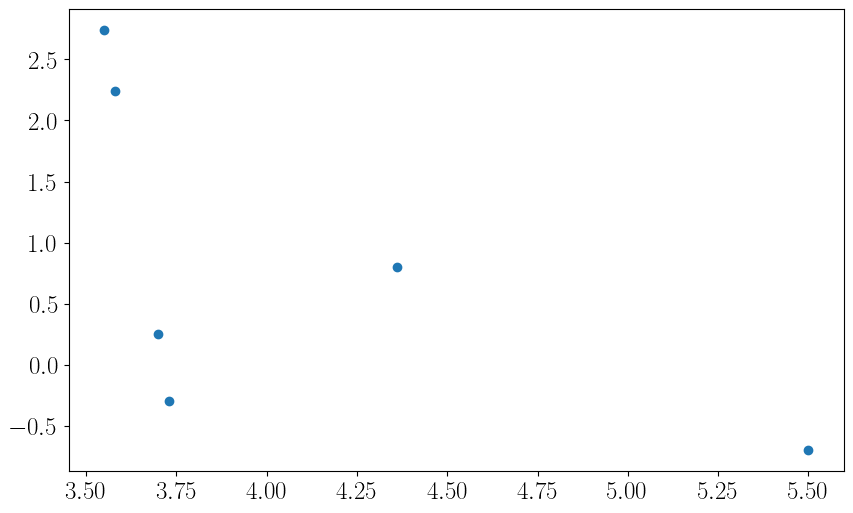

In [37]:
df_row_TRP1 = df_row_all[(df_row_all["RES_1"] == "TRP") | (df_row_all["RES_2"] == "TRP")]
df_row_TRP1 = df_row_all[(df_row_all["ATOM_1"].str.contains("HE|HD|HZ|HH")) | (df_row_all["ATOM_2"].str.contains("HE|HD|HZ|HH"))]
plt.scatter(df_row_TRP1["UPL"], df_row_TRP1["rNOE_1_UPL"] - df_row_TRP1["rNOE_2_UPL"])